# Clustering

Clustering is an unsupervised classification task that tries to divide input data into groups of similar elements. We will explore several applications

* Clustering 1-dimensional data   
  - Thresholding gray-level images with Otsu thresholding
   
   
* Clustering multi-dimensional data using K-Means    
  - Numerical data: IRIS dataset
  - Clustering colors: RGB images


* Clustering pixels in both space and color
  - SLIC superpixels
  
  
* Clustering objects/regions
  - Letter soup
  
  
**Keywords:**
- Otsu, K-Means, SLIC, region properties
- Label image, scatter matrix plot, confusion matrix, data scaling

In [1]:
# IMPORTS

%load_ext autoreload
%autoreload 2

from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['figure.figsize'] = (8,3)
from skimage import io, color
import skdemo
from skdemo import show_segmentation, discrete_colorbar, show_features

## Clustering 1-dimensional data


### Otus thresholding

Image binarization is a common operation. For grayscale images, finding the best threshold for binarization can be a manual operation. Alternatively, algorithms can select a threshold value automatically; which is convenient for computer vision, or for batch-processing a series of images.

Otsu algorithm is the most famous thresholding algorithm. It maximizes the variance between the two segmented groups of pixels. Therefore, it is can be interpreted as a **clustering** algorithm. Samples are pixels and have a single feature, which is their grayscale value.

In [2]:
from skimage import data, exposure, filters
camera = data.camera()

In [3]:
hi = exposure.histogram(camera)

In [16]:
val = filters.threshold_otsu(camera)
print('Otsu threshold = ',val)

Otsu threshold =  87


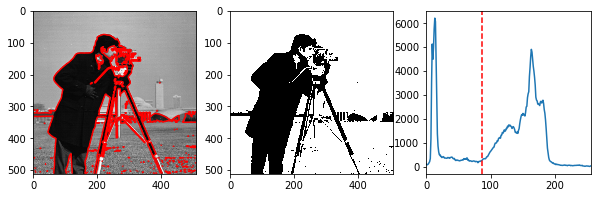

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].imshow(camera, cmap='gray')
axes[0].contour(camera, [val], colors='r')
axes[1].imshow(camera>val, cmap='gray')
axes[2].plot(hi[1], hi[0]); axes[2].set_xlim(0,255)
axes[2].axvline(val, ls='--', c='r')

How can we transpose the idea of Otsu thresholding to RGB or multichannel images? We can use the k-means algorithm, which aims to partition samples in k clusters, where each sample belongs to the cluster of nearest mean. 

## Clustering multi-dimensional data

### Numerical data: Iris dataset

Below we show a simple example of k-means clustering, based on the Iris dataset of ``scikit-learn``. Note that the ``KMeans`` estimator
uses a similar API as the SVC we used for digits classification, with the .fit method.

In [4]:
# From http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target
dict.keys(iris)

dict_keys(['target_names', 'target', 'DESCR', 'data', 'feature_names'])

In [113]:
#print(iris.DESCR)

We can display 2D scatter plots to get an idea of the variations and dependences between features.

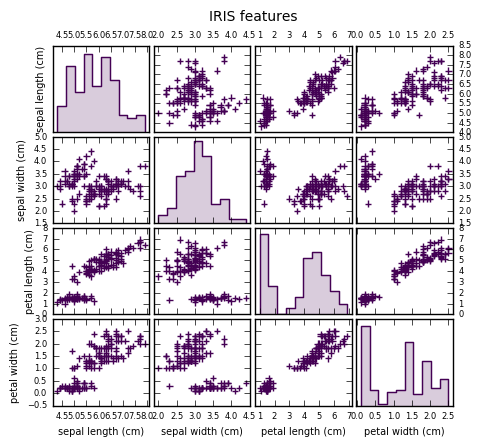

In [8]:
from skdemo import scatter_matrix
fig=scatter_matrix(iris.data, c=None, labels=iris.feature_names, 
                  title='IRIS features', figsize=(4,4))

Let's use K-Means to find natural clusters from the data

In [10]:
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

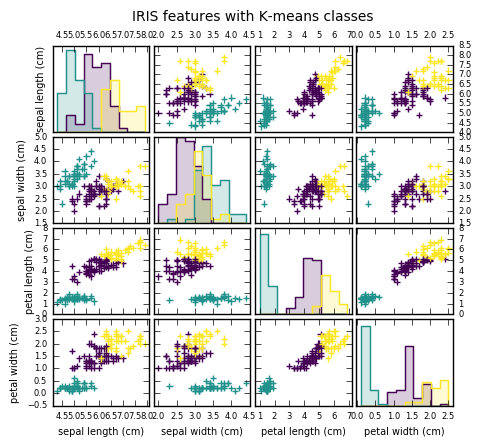

In [11]:
fig=scatter_matrix(iris.data, labels, iris.feature_names, 
                  title='IRIS features with K-means classes', figsize=(4,4))

In [48]:
# Notebook: uncomment this to run next cell in interactive mode 
# (try to run this cell several times if does not get out of inline mode)
#%matplotlib
#%matplotlib auto

Using matplotlib backend: MacOSX
Using matplotlib backend: MacOSX


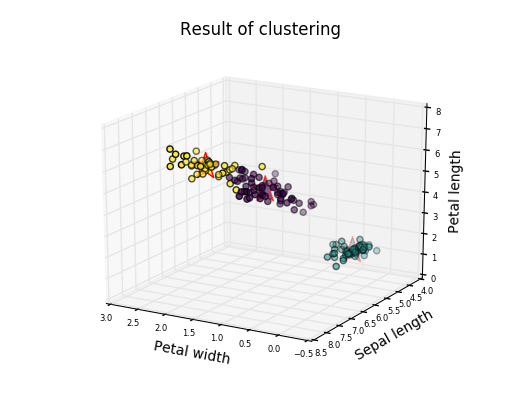

In [62]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5, 4))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=20, azim=120)
# Plot samples
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), cmap='viridis')
# Plot K-means centers
ax.scatter(centers[:,3], centers[:,0], centers[:,2], c=[0,1,2], s=400, marker='*', edgecolor='red', cmap='viridis')

ax.dist=12
ax.tick_params(pad=-2,labelsize=6)
ax.set_xlabel('Petal width', labelpad=0)
ax.set_ylabel('Sepal length', labelpad=0)
ax.set_zlabel('Petal length', labelpad=-4);
ax.set_title('Result of clustering')

plt.show()

In [52]:
# Notebook: Uncomment this to come back to inline mode
#%matplotlib inline

Actually, for this dataset, we know the true labels: `iris.target`.

We can evaluate the overlap between the known labels (groundtruth) and the clustering obtained without any supervision using a confusion matrix. Item at position $(i,j)$ in the table represents the number of samples that are in category $i$ and where classified into cluster $j$.

Since the clustering does not take any labels during the fitting step, the order of the labels is arbitrary. Trying to match groundtuth and clusters require a reordering first to try to have most samples on the diagonal ($i=j$). In this example, we do this manually.

In [24]:
import sklearn as sl
reorder = np.array([1,0,2]) # Need to rearange order each time KMeans is computed
confmat=sl.metrics.confusion_matrix(y,reorder[labels])

import pandas as pd # For pretty printing
pd.DataFrame(confmat,index=['truth={}'.format(x) for x in [0,1,2]],
                     columns=['cluster={}'.format(x) for x in [0,1,2]])

,cluster=0,cluster=1,cluster=2
truth=0,50,0,0
truth=1,0,48,2
truth=2,0,14,36


We can visualize both groundtruth and clustering side by side, as well as the centers estimated by the KMeans algorithm

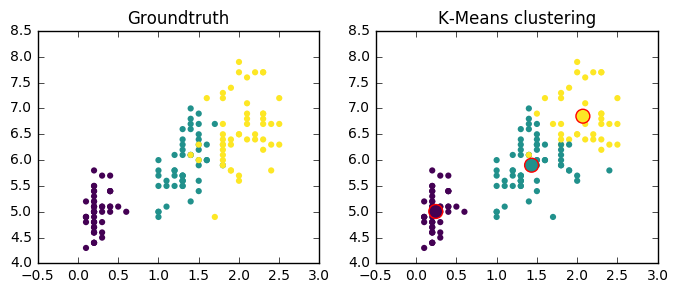

In [25]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

plt.sca(axes[0])
plt.scatter(iris.data[:,3], iris.data[:,0], c=iris.target,
            cmap='viridis', marker='o', edgecolor='none')
plt.title('Groundtruth')

plt.sca(axes[1])
plt.scatter(iris.data[:,3], iris.data[:,0], c=reorder[labels],
            cmap='viridis', marker='o', edgecolor='none')

plt.scatter(centers[:,3], centers[:,0], c=reorder, 
            cmap='viridis', marker='o', s=100, edgecolor='red');
plt.title('K-Means clustering')

### Clustering RGB data

K-means works with any numerical data. For instance, values of pixel color which form a numerical vector. 

K-means clustering uses the Euclidean distance in feature space to cluster samples. If we want to cluster together pixels of similar color, the RGB space is not well suited since it mixes together information about color and light intensity. Therefore, we first transform the RGB image into [Lab colorspace](https://en.wikipedia.org/wiki/Lab_color_space), and only use the color channels (a and b) for clustering.

In [136]:
from skimage import io, color
im = io.imread('../images/round_pill.jpg')
im_lab = color.rgb2lab(im)

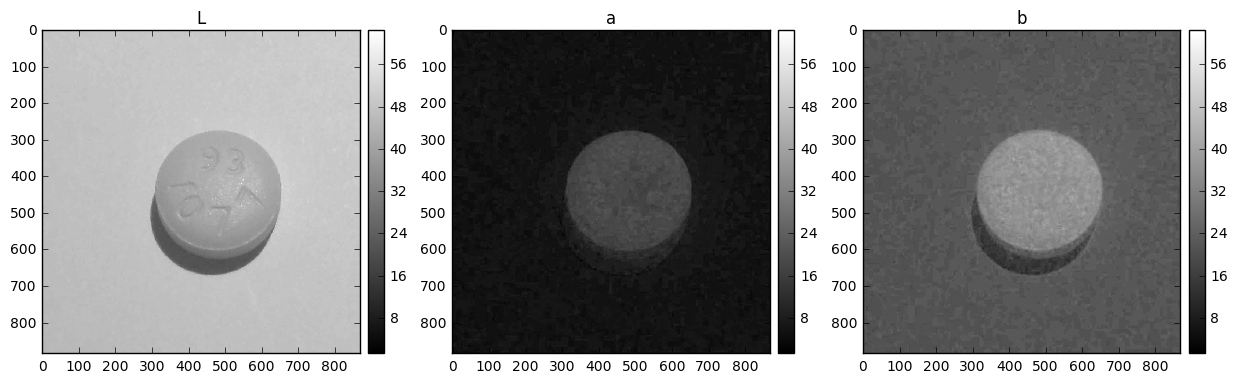

In [137]:
import skdemo
titles=['L','a','b']
skdemo.imshow_all(im_lab[..., 0], im_lab[..., 1], im_lab[..., 2], titles=titles)
skdemo.colorbars()

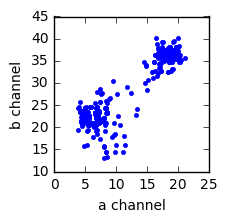

In [153]:
data = np.array([im_lab[..., 1].ravel(), im_lab[..., 2].ravel()])

# Get the ids of a random subset of 1000 samples
perm=np.random.permutation(data.shape[1])
ids=perm[0:1000]
plt.figure(figsize=(2,2))
plt.plot(data[0,ids],data[1,ids],'.') # Scatter plot of a random subset of data
plt.xlabel('a channel')
plt.ylabel('b channel')

We notice that the colors organize naturally into 2 clusters. Let's use K-Means to find them automatically.

We create a ``KMeans`` estimator for two clusters, and display the clustering as scatter plot in color space.

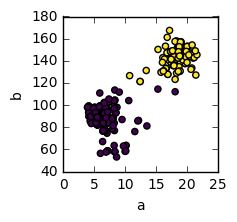

In [151]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

plt.figure(figsize=(2,2))
plt.scatter(data[0,ids],data[1,ids],c=kmeans.labels_[ids].astype(float),cmap='viridis')
plt.xlabel('a')
plt.ylabel('b')

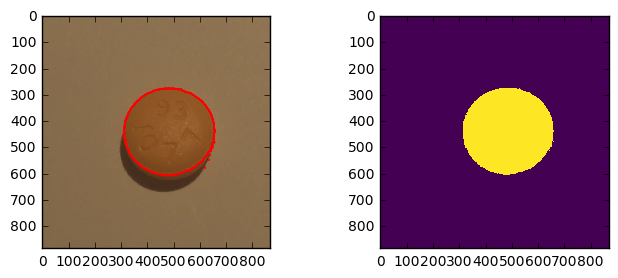

In [152]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(im)
axes[0].contour(segmentation, colors='r')
axes[1].imshow(segmentation, cmap='viridis')

#show_segmentation(im, segmentation, [[1,0,0],[0,0,1]])

__Application to `chapel` image__

Of course we can generalize this method to more than two clusters.

In [31]:
im = io.imread('../images/chapel_floor.png')
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 0].ravel(),
                 im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=4, random_state=0).fit(data.T)
labels = kmeans.labels_.astype(np.float)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

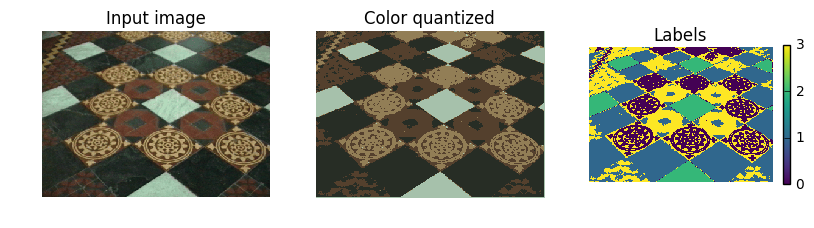

In [32]:
color_mean = color.label2rgb(segmentation, im, kind='mean')
fig, axes = plt.subplots(1, 3, figsize=(10,3))
plt.sca(axes[0])
plt.imshow(im)
plt.title('Input image')

plt.sca(axes[1])
plt.imshow(color_mean)
plt.title('Color quantized')

plt.sca(axes[2])
plt.imshow(segmentation, cmap='viridis')
plt.colorbar(ticks=range(4),shrink=0.6)
plt.title('Labels')

for ax in axes:
    ax.axis('off')
fig.subplots_adjust()

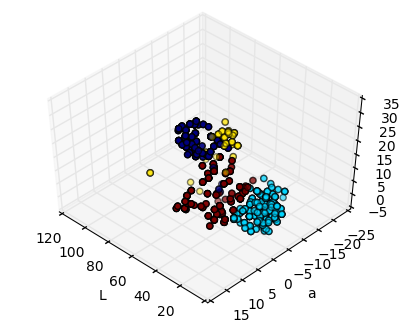

In [33]:
perm=np.random.permutation(kmeans.labels_.size)
ids=perm[0:1000]

fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(data[0,ids], data[1,ids], data[2,ids], c=labels[ids], cmap='jet')
ax.set_xlabel('L'); ax.set_ylabel('a'); ax.set_zlabel('b')

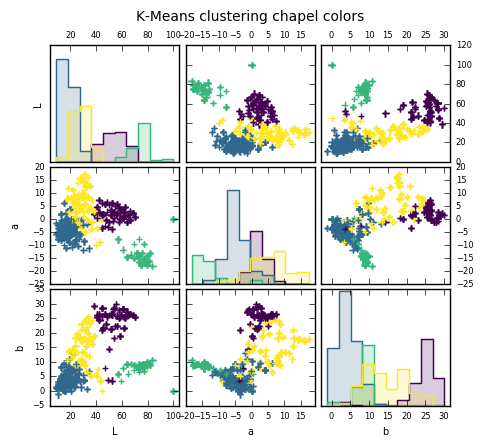

In [34]:
fig=scatter_matrix(data[:,ids].T, segmentation.ravel()[ids], labels=['L','a','b'],
                  title='K-Means clustering chapel colors', figsize=(4,4))

### Exercise:

For the chapel floor image, cluster the image in 3 clusters, using only the color channels (not the lightness one). What happens?

## SLIC algorithm: clustering using color and spatial features

In the thresholding / vector quantization approach presented above, pixels are characterized only by their color features. However, in most images neighboring pixels correspond to the same object. Hence, information on spatial proximity between pixels can be used in addition to color information.

SLIC (Simple Linear Iterative Clustering) is a segmentation algorithm which clusters pixels in both space and color. Therefore, regions of space that are similar in color will end up in the same segment.

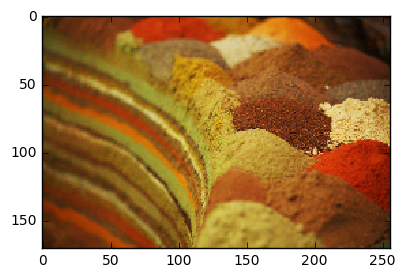

In [35]:
from skimage import io, color
spices = io.imread('../images/spices.jpg')

from skimage import transform
spices = transform.rescale(spices, 0.25) # Resize to reduce compute time

plt.imshow(spices)

Let us try to segment the different spices using the previous k-means approach. One problem is that there is a lot of texture coming from the relief and shades.

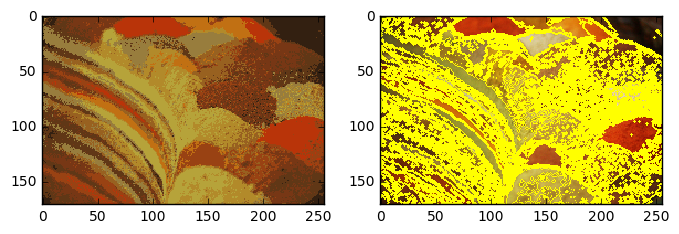

In [36]:
from sklearn.cluster import KMeans
from skimage import segmentation

im_lab = color.rgb2lab(spices)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=10, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])

fig, axes = plt.subplots(1,2)
color_mean = color.label2rgb(labels, spices, kind='mean')
axes[0].imshow(color_mean)
axes[1].imshow(segmentation.mark_boundaries(spices, labels))

Including the x,y coordinates as input to the K-Means helps keeping each cluster spatially grouped. But it does not guarantee it stays spatially connected, as noticed on some boundaries between clusters.

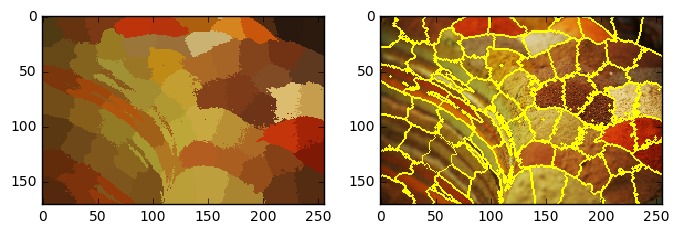

In [37]:
ygrid, xgrid = np.mgrid[range(im_lab.shape[0]),range(im_lab.shape[1])]
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel(),
                 xgrid.ravel(), ygrid.ravel()])

kmeans = KMeans(n_clusters=70, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])

fig, axes = plt.subplots(1,2)
plt.sca(axes[0])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(color_mean)
plt.sca(axes[1])
plt.imshow(segmentation.mark_boundaries(spices, labels))

SLIC is a superpixel algorithm, which segments an image into patches (superpixels) of neighboring pixels with a similar color, and guarantee each segment is spatially connected. SLIC also works in the Lab colorspace. The ``compactness`` parameter controls the relative importance of the distance in image- and color-space.

In [38]:
from skimage import segmentation
segments = segmentation.slic(spices, n_segments=200, compactness=20)

fig, axes = plt.subplots(1,2)
slic_mean = color.label2rgb(segments, spices, kind='mean')
axes[0].imshow(slic_mean)
axes[1].imshow(segmentation.mark_boundaries(spices, segments))

After the super-pixel segmentation (which is also called oversegmentation, because we end up with more segments that we want to), we can add a second clustering step to join superpixels belonging to the same spice heap.

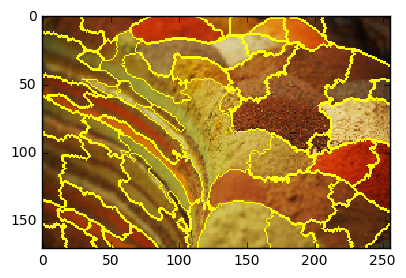

In [40]:
im_lab = color.rgb2lab(slic_mean)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=10, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(segmentation.mark_boundaries(spices, labels))

Note that other superpixel algorithms are available, such as **Felzenswalb** segmentation. It uses a Minimum Spanning Tree of the image grid, which also enforces connectivity, but allows more elongated segments.

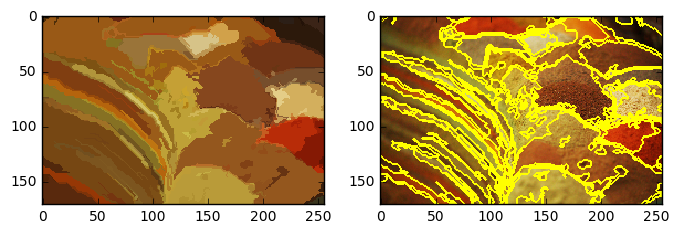

In [41]:
result = segmentation.felzenszwalb(spices, scale=100)

fig, axes = plt.subplots(1,2)
color_mean = color.label2rgb(result, spices, kind='mean')
axes[0].imshow(color_mean)
axes[1].imshow(segmentation.mark_boundaries(spices, result))

### Exercise

Repeat the same operations (SLIC superpixel segmentation, followed by K-Means clustering on the average color of superpixels) on the astronaut image. Vary the following parameters
- slic: n_segments and compactness
- KMeans: n_clusters (start with 8 for example)

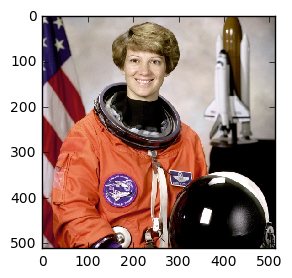

In [42]:
from skimage import data
astro = data.astronaut()
plt.imshow(astro)

In [43]:
# solution goes here

## Clustering objects/regions

We have already seen how to use ``skimage.measure.regionprops`` to extract the properties (area, perimeter, ...) of labeled objects. These properties can be used as features in order to cluster the objects in different groups, or to classify them if given a training set.

In the example below, we use ``skimage.data.binary_blobs`` to generate a binary image. We use several properties to generate features: the area, the ratio between squared perimeter and area, and the solidity (which is the area fraction of the object as compared to its convex hull). 

We would like to make sense of these letter soup images without having to annotate them manually. Clustering can help by highlighting the main groups.

32


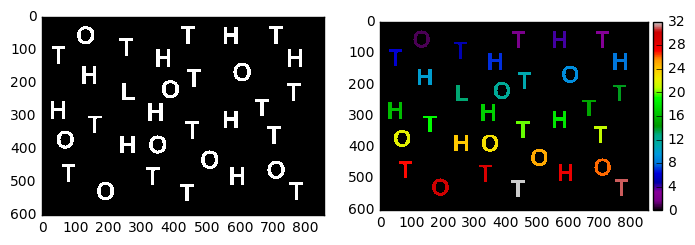

In [64]:
from skimage import measure
from skimage import data
#im = data.binary_blobs(length=1024, blob_size_fraction=0.05, volume_fraction=0.15)
#im = io.imread('../images/snellen_chart.png')
im = color.rgb2gray(io.imread('../images/letter_soup.png'))<0.5
#im = (im+np.random.rand(*im.shape)*0.10)<0.5
#im = color.rgb2gray(im)<1

label_image = measure.label(im) # Connected components

fig,axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[1].imshow(label_image, cmap='spectral')
skdemo.colorbars(axes[1])

print(np.max(label_image))

Each connected region has a label and we can measure their properties.

A simple property is the centroid, which give a single `(y,x)` point at the center of each region.

[-50, 906, 654, -50]

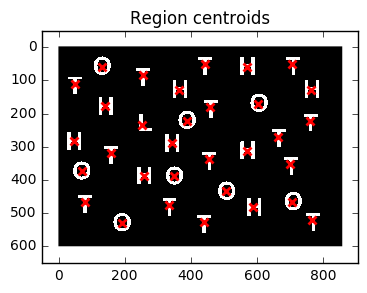

In [65]:
props = measure.regionprops(label_image)
centroids = np.array( [prop.centroid for prop in props] )

plt.imshow(im, cmap='gray')
plt.plot(centroids[:,1],centroids[:,0],'xr',markeredgewidth=2)
plt.title('Region centroids')
plt.axis([-50,im.shape[1]+50,im.shape[0]+50,-50])

But to cluster the regions, we need features that will be invariant (similar from one letter to the same letter in a different position). After creating a table of the useful properties, we can reproject their values back to the image as a set of feature maps to get an idea of which features help differentiating between the letters:

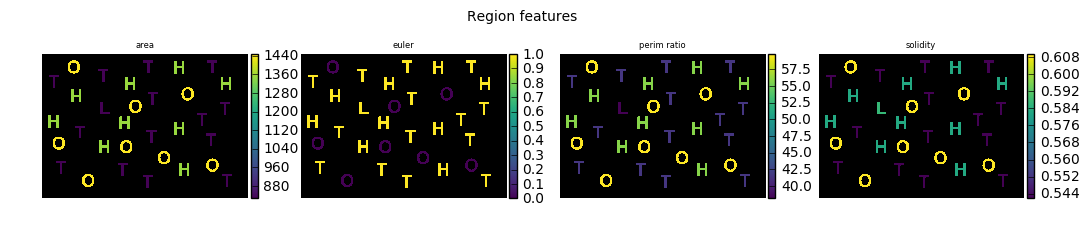

In [66]:
# Be careful: since value 0 in label_image is the background,
# props[i] i=0..n-1 corresponds to label i+1 in label_image
featdata = np.array([(prop.area, prop.euler_number,
                  prop.perimeter**2/prop.area,
                  prop.solidity) for prop in props])
proplabels = ['area', 'euler','perim ratio', 'solidity']

def reshape_properties(data, label_image, bg=0.0):
    """
    Create an image same size as label_image such that 
    all pixels at 0 become `bg`
    all pixels with index i are mapped to `data[i-1]`.
    
    data: array of shape (nb_regions, nb_features)
    """
    if (data.ndim<2):
        data=data.reshape(data.size,1)
    nb_features=data.shape[1]
    prop_image = np.empty([label_image.shape[0],label_image.shape[1],nb_features])
    prop_image[label_image==0,:] = bg
    prop_image[label_image>0,:] = data[label_image[label_image>0]-1,:]
    return prop_image

featimage = reshape_properties(featdata,label_image, bg=np.nan)

import matplotlib as mpl
cmap = mpl.cm.viridis
cmap.set_bad('k') # Color for `nan` values
fig=show_features(featimage, proplabels, axsize=(3.2,2.5), cmap=cmap)
fig.suptitle('Region features')
skdemo.colorbars()

We use the KMeans algorithm to cluster the objects. We visualize the result as an array of labels.

[2 1 1 0 1 1 0 0 2 0 1 2 1 1 1 0 0 0 1 1 1 2 2 0 2 2 1 0 1 2 1 1]


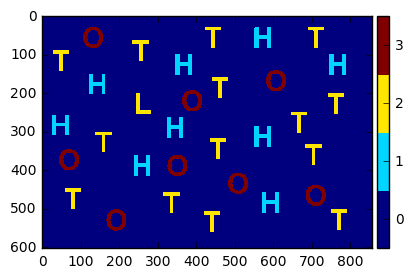

In [72]:
from sklearn.cluster import KMeans
from skdemo import discrete_cmap
from matplotlib.colors import NoNorm

N=3
clf = KMeans(n_clusters=N)
clf.fit(featdata)

print(clf.labels_)
    
def reshape_cluster_labels(cluster_labels, label_image):
    """
    Create an image same size as label_image such that 
    all pixels at 0 stay at 0
    all pixels with index i are mapped to cluster_label[i-1]+1
    """
    cluster_labels = np.concatenate(([0], cluster_labels + 1))
    return cluster_labels[label_image]
    
object_clusters = reshape_cluster_labels(clf.labels_, label_image)
plt.imshow(object_clusters, cmap=discrete_cmap(N+1,cmap='jet',use_bounds=True), norm=NoNorm())
skdemo.colorbars()

The scatter plot helps understanding which features differentiated between the letters:

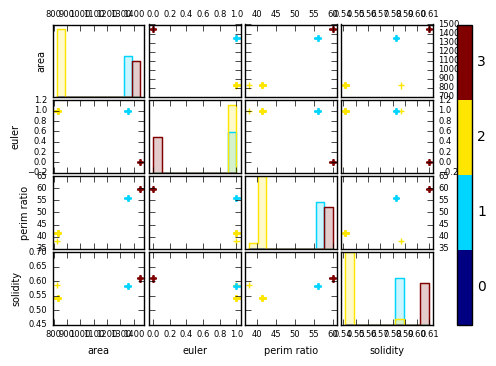

In [73]:
from matplotlib.colors import ListedColormap, NoNorm

fig=scatter_matrix(featdata, clf.labels_+1, labels=proplabels,
                  cmap='jet',show_colorbar=True,
                  figsize=(5,3))

Let's try again with a more challenging image

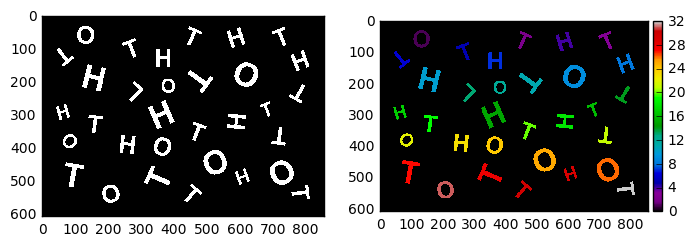

In [74]:
im = color.rgb2gray(io.imread('../images/letter_soup3.png'))<0.5

label_image = measure.label(im) # Connected components

fig,axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[1].imshow(label_image, cmap='spectral')
skdemo.colorbars(axes[1])

In this case, the `area` property may not be relevant to cluster by letter type, we remove it from the features:

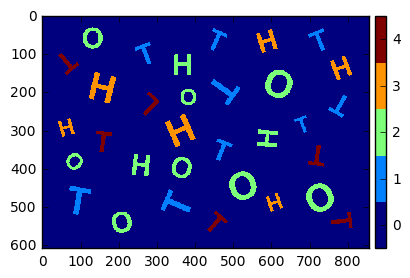

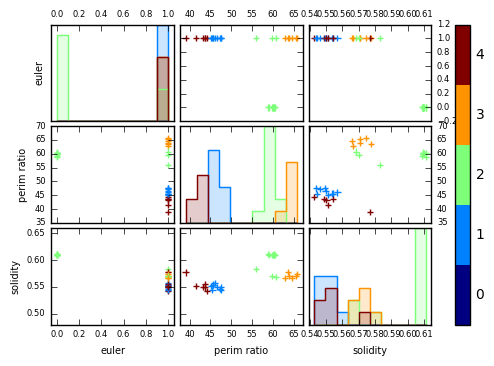

In [75]:
props = measure.regionprops(label_image)

featdata = np.array([(prop.euler_number,
                  prop.perimeter**2/prop.area,
                  prop.solidity) for prop in props])
proplabels = ['euler','perim ratio', 'solidity']

N=4
clf = KMeans(n_clusters=N)
clf.fit(featdata)

object_clusters = reshape_cluster_labels(clf.labels_, label_image)
plt.imshow(object_clusters, cmap=discrete_cmap(N+1,cmap='jet',use_bounds=True), norm=NoNorm())
skdemo.colorbars()

fig=scatter_matrix(featdata, clf.labels_+1, labels=proplabels,
                  cmap='jet',show_colorbar=True,
                  figsize=(5,3))

If we look carefully at the scatter plots, the clustering is almost uniquely based on the `perim ratio` feature.  Since various features have different ranges, they do not have the same influence on the final clustering. `perim ratio` has a much larger range, the other features are almost ignored.

To avoid that, we can use the scaling methods provided by ``sklearn.preprocessing``. The ``StandardScaler`` makes sure that every feature has a zero mean and a unit standard deviation.

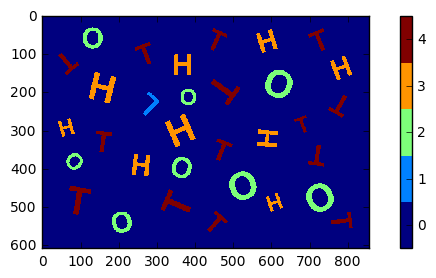

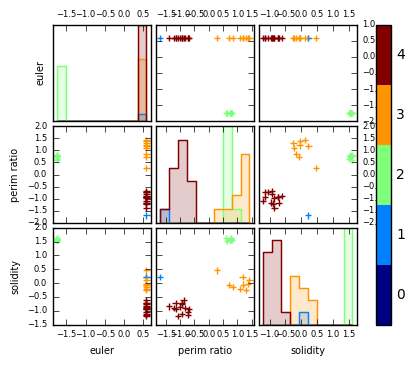

In [78]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()
data_scaled = min_max_scaler.fit_transform(featdata)

N=4
clf = KMeans(n_clusters=N)

clf.fit(data_scaled)

object_clusters = reshape_cluster_labels(clf.labels_, label_image)
plt.imshow(object_clusters, cmap=discrete_cmap(N+1,cmap='jet',use_bounds=True), norm=NoNorm())
plt.colorbar()

fig=scatter_matrix(data_scaled,clf.labels_+1,labels=proplabels,cmap='jet',figsize=(4,3), show_colorbar=True)

### Exercise

Segment and cluster the diatomeas in various shapes using KMeans clustering

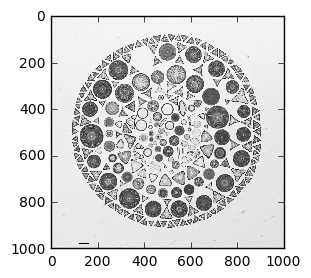

In [154]:
from skimage import filters, img_as_float
im0 = color.rgb2gray(io.imread('../images/8981509345_b8266b5afc_o.jpg'))
#im0 = color.rgb2gray(io.imread('../images/8981509897_10f350cacf_o.jpg'))
#im0 = color.rgb2gray(io.imread('../images/Diatoms-microscopy-ukorguk.jpg'))

plt.imshow(im0, cmap='gray')

Document history:
- Oct 2017: Extracted from `lectures/machine_learning.ipynb` from https://github.com/scikit-image/skimage-tutorials (License CC0 1.0 Universal)
- Oct 2017, Rémi Mégret: Focus on clustering only.
  - Added short intro
  - Added scatter matrix plots (see also `skdemo.py`)
  - Replaced object clustering with the 'letter soup' example